# Predicting Used Car Prices

### 1. Setup and Data Loading

**Objective**

The primary objective of this notebook is to develop and document a robust machine learning model to accurately predict the price of used cars. This involves a comprehensive process of data cleaning, feature engineering, model training, and comparative analysis to identify the most effective algorithm for this task. The final deliverable is a saved, production-ready model capable of making price predictions on new data.

**Business Importance**

- **Enhancing Market Insights:** By identifying the key drivers of used car prices , the model provides actionable intelligence for pricing strategy and inventory acquisition.

- **Improving Customer Trust:** Providing transparent and data-driven price estimates helps buyers and sellers make informed decisions, building trust and improving user experience on the platform.

- **Optimizing Inventory Management:** A reliable price prediction model allows the business to optimize stock, avoid overpaying for inventory, and price vehicles competitively to maximize turnover and profit margins.

In [261]:
# Import libraries for data manipulation, visualization and modeling
import pandas as pd
import numpy as np
import datetime
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [234]:
# Load the dataset
data= pd.read_csv('usedCars.csv')

In [235]:
data.head()

,Id,Company,Model,Variant,FuelType,Colour,Kilometer,BodyStyle,TransmissionType,ManufactureDate,ModelYear,CngKit,Price,Owner,DealerState,DealerName,City,Warranty,QualityScore
0,555675,MARUTI SUZUKI,CELERIO(2017-2019),1.0 ZXI AMT O,PETROL,Silver,33197,HATCHBACK,NaN,2018-02-01,2018,NaN,5.75 Lakhs,1st Owner,Karnataka,Top Gear Cars,Bangalore,1,7.8
1,556383,MARUTI SUZUKI,ALTO,LXI,PETROL,Red,10322,HATCHBACK,Manual,2021-03-01,2021,NaN,4.35 Lakhs,1st Owner,Karnataka,Renew 4 u Automobiles PVT Ltd,Bangalore,1,8.3
2,556422,HYUNDAI,GRAND I10,1.2 KAPPA ASTA,PETROL,Grey,37889,HATCHBACK,Manual,2015-03-01,2015,NaN,4.7 Lakhs,1st Owner,Karnataka,Anant Cars Auto Pvt Ltd,Bangalore,1,7.9
3,556771,TATA,NEXON,XT PLUS,PETROL,A Blue,13106,HATCHBACK,NaN,2020-08-01,2020,NaN,9.9 Lakhs,1st Owner,Karnataka,Adeep Motors,Bangalore,1,8.1
4,559619,FORD,FIGO,EXI DURATORQ 1.4,DIESEL,Silver,104614,HATCHBACK,Manual,2010-11-01,2010,NaN,2.7 Lakhs,2nd Owner,Karnataka,Zippy Automart,Bangalore,0,7.5


In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1064 non-null   int64  
 1   Company           1064 non-null   object 
 2   Model             1064 non-null   object 
 3   Variant           1064 non-null   object 
 4   FuelType          1063 non-null   object 
 5   Colour            1064 non-null   object 
 6   Kilometer         1064 non-null   int64  
 7   BodyStyle         1064 non-null   object 
 8   TransmissionType  350 non-null    object 
 9   ManufactureDate   1064 non-null   object 
 10  ModelYear         1064 non-null   int64  
 11  CngKit            22 non-null     object 
 12  Price             1064 non-null   object 
 13  Owner             1064 non-null   object 
 14  DealerState       1064 non-null   object 
 15  DealerName        1064 non-null   object 
 16  City              1064 non-null   object 


# 2. Feature Engineering

In [237]:
# Replace ' Lakhs' and ',' then convert to float
def clean_price(price):
    price_str = str(price).replace(',', '')
    if 'Lakhs' in price_str:
        return float(price_str.replace(' Lakhs', '')) * 100000
    else:
        return float(price_str)

data['Price'] = data['Price'].apply(clean_price)

In [238]:
# Create CarAge
current_year = 2025
data['CarAge'] = current_year - data['ModelYear']

In [239]:
# Create company Category
luxury_brands = ['MERCEDES BENZ', 'BMW', 'AUDI', 'VOLVO', 'JEEP']
mid_range_brands = ['TOYOTA', 'HONDA', 'HYUNDAI', 'VOLKSWAGEN', 'KIA', 'SKODA','FIAT','MG','MITSUBISHI','CHEVROLET','ISUZU','FORD']
budget_brands = ['MARUTI SUZUKI', 'TATA', 'DATSUN', 'RENAULT', 'MAHINDRA','NISSAN']

def categorize_brand(company):
    if company in luxury_brands:
        return 'Luxury'
    elif company in mid_range_brands:
        return 'Mid-Range'
    else: # All other brands fall into Budget
        return 'Budget'

data['Category'] = data['Company'].apply(categorize_brand)

In [240]:
# Fill missing TransmissionType values with the mode (most frequent value)
mode_transmission = data['TransmissionType'].mode()[0]
data['TransmissionType'].fillna(mode_transmission, inplace=True)

# Fill missing TransmissionType values with the mode (most frequent value)
mode_fuel = data['FuelType'].mode()[0]
data['FuelType'].fillna(mode_fuel, inplace=True)

In [241]:
# Drop Unnecessary Columns
columns_to_drop = ['Id', 'ManufactureDate', 'ModelYear', 'Variant', 'CngKit','DealerName', 'DealerState']
data.drop(columns=columns_to_drop, inplace=True)

In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1064 non-null   object 
 1   Model             1064 non-null   object 
 2   FuelType          1064 non-null   object 
 3   Colour            1064 non-null   object 
 4   Kilometer         1064 non-null   int64  
 5   BodyStyle         1064 non-null   object 
 6   TransmissionType  1064 non-null   object 
 7   Price             1064 non-null   float64
 8   Owner             1064 non-null   object 
 9   City              1064 non-null   object 
 10  Warranty          1064 non-null   int64  
 11  QualityScore      1064 non-null   float64
 12  CarAge            1064 non-null   int64  
 13  Category          1064 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 116.5+ KB


# 3. Separate Features (X) and Target (y)

In [243]:
X = data.drop('Price', axis=1)
y = data['Price']

# 4. Split Data into Training and Testing Sets

In [244]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Preprocessing Pipeline

In [245]:
# Create the Preprocessing Pipeline
# First, identify which columns are numerical and which are categorical
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough' # This ensures no columns are accidentally dropped
)

# 6. Pipeline for the Data

In [246]:
# Apply the Pipeline to the Data
# Fit the preprocessor on the training data and transform both the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Verification Step to ensure everything is correct
print("Shape of original training features:", X_train.shape)
print("Shape of processed training features:", X_train_processed.shape)
print("Shape of original test features:", X_test.shape)
print("Shape of processed test features:", X_test_processed.shape)

Shape of original training features: (851, 13)
Shape of processed training features: (851, 328)
Shape of original test features: (213, 13)
Shape of processed test features: (213, 328)


# 7. Building Baseline Models

In [247]:
# 1. Define and Train All Baseline Models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=42, max_iter=2000), # Increased max_iter to aid convergence
    'Ridge Regression': Ridge(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [248]:
# 2. Dictionary to store results
results = {}

# Train, evaluate, and store results for each model
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    
    results[name] = {
        'model': model,
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [249]:
# 3. Display Model Performance Comparison
# Create a pandas DataFrame from the results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean Squared Error (MSE)': [results[m]['MSE'] for m in results],
    'Mean Absolute Error (MAE)': [results[m]['MAE'] for m in results],
    'R-squared (R2)': [results[m]['R2'] for m in results]
}).sort_values(by='R-squared (R2)', ascending=False)

print("--- Baseline Model Performance ---")
# Format the numbers for better readability
results_df['Mean Squared Error (MSE)'] = results_df['Mean Squared Error (MSE)'].map('{:,.2f}'.format)
results_df['Mean Absolute Error (MAE)'] = results_df['Mean Absolute Error (MAE)'].map('{:,.2f}'.format)
results_df['R-squared (R2)'] = results_df['R-squared (R2)'].map('{:.3f}'.format)
print(results_df.to_string(index=False))

--- Baseline Model Performance ---
            Model Mean Squared Error (MSE) Mean Absolute Error (MAE) R-squared (R2)
 Ridge Regression        50,341,888,422.33                138,983.47          0.790
    Decision Tree        60,645,427,230.05                164,910.80          0.747
Linear Regression        64,051,624,840.43                146,670.94          0.732
 Lasso Regression        64,491,699,590.96                148,274.76          0.730
Gradient Boosting        73,304,974,510.56                154,979.60          0.694
    Random Forest        73,907,647,265.26                147,181.92          0.691


In [250]:
# 4. Analyze and Display Feature Importance for ALL Models
# Get the complete list of feature names from the preprocessor
try:
    feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    numerical_features_list = numerical_features.tolist()
    all_feature_names = numerical_features_list + feature_names_cat.tolist()
except AttributeError: # For older scikit-learn versions
    feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
    numerical_features_list = numerical_features.tolist()
    all_feature_names = numerical_features_list + feature_names_cat.tolist()


# Loop through each trained model and print its top features
for name, result in results.items():
    print(f"\n--- Feature Analysis for: {name} ---")
    
    # For Tree-based models (Decision Tree, Random Forest, Gradient Boosting)
    if hasattr(result['model'], 'feature_importances_'):
        importances = result['model'].feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        print("Top 5 Most Important Features:")
        print(feature_importance_df.head(5).to_string(index=False))
        
    # For Linear models (Linear, Lasso, Ridge)
    elif hasattr(result['model'], 'coef_'):
        coefficients = result['model'].coef_
        feature_coeffs_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
        
        # Show features with largest positive and negative impact
        feature_coeffs_df = feature_coeffs_df.reindex(feature_coeffs_df['Coefficient'].abs().sort_values(ascending=False).index)
        
        print("Top 5 Features by Magnitude of Coefficient:")
        print(feature_coeffs_df.head(5).to_string(index=False))
    
    else:
        print("Feature importance or coefficients are not available for this model.")


--- Feature Analysis for: Linear Regression ---
Top 5 Features by Magnitude of Coefficient:
                   Feature  Coefficient
Model_ENDEAVOUR(2016_2019) 2.011439e+06
           Model_ENDEAVOUR 1.658123e+06
            Model_FORTUNER 1.402000e+06
     Model_CITY(2017-2020) 1.384675e+06
            Model_ML CLASS 1.320262e+06

--- Feature Analysis for: Lasso Regression ---
Top 5 Features by Magnitude of Coefficient:
                   Feature  Coefficient
Model_ENDEAVOUR(2016_2019) 2.310709e+06
           Model_ENDEAVOUR 1.958233e+06
     Model_CITY(2017-2020) 1.521994e+06
              Model_SAFARI 1.291079e+06
            Model_ML CLASS 1.289560e+06

--- Feature Analysis for: Ridge Regression ---
Top 5 Features by Magnitude of Coefficient:
                   Feature  Coefficient
     Model_CITY(2017-2020) 1.193781e+06
           Model_ENDEAVOUR 1.071513e+06
            Model_FORTUNER 9.785955e+05
              Model_XUV700 8.862516e+05
Model_ENDEAVOUR(2016_2019) 8.858177e+05

--

# 8. Tuning Models

In [251]:
# 1. Define Models and Parameter Grids for Tuning
# Note: Grids are kept small to ensure timely execution.
param_grids = {
    'Ridge Regression': {
        'alpha': [1.0, 10.0, 50.0], # Regularization strength
        'solver': ['auto', 'svd']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15], # Max depth of the tree
        'min_samples_split': [2, 10, 20], # Min samples to split a node
        'min_samples_leaf': [1, 5, 10] # Min samples in a leaf node
    },
    'Random Forest': {
        'n_estimators': [100, 200], # Number of trees
        'max_depth': [10, 20], # Max depth of trees
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200], # Number of boosting stages
        'learning_rate': [0.05, 0.1], # Step size shrinkage
        'max_depth': [3, 5]
    }
}

In [252]:
# Linear Regression has no hyperparameters to tune, so we'll evaluate it as is.
models_to_tune = {
    'Ridge Regression': Ridge(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

tuned_results = {}

In [253]:
# 2. Perform GridSearchCV for each model
for name, model in models_to_tune.items():
    print(f"--- Starting Hyperparameter Tuning for: {name} ---")
    start_time = time.time()
    
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grids[name], 
                      cv=3, # 3-fold cross-validation
                      scoring='r2', 
                      n_jobs=-1) # Use all available CPU cores
    
    gs.fit(X_train_processed, y_train)
    
    end_time = time.time()
    print(f"Tuning completed in {end_time - start_time:.2f} seconds.")
    print(f"Best R-squared score on validation data: {gs.best_score_:.3f}")
    print(f"Best Parameters: {gs.best_params_}")
    
    # Evaluate the best model on the test set
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test_processed)
    
    tuned_results[name] = {
        'model': best_model,
        'Best Params': gs.best_params_,
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Add the untuned Linear Regression for comparison
lr = LinearRegression().fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)
tuned_results['Linear Regression'] = {
    'model': lr, 'Best Params': 'N/A',
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr), 'R2': r2_score(y_test, y_pred_lr)
}

--- Starting Hyperparameter Tuning for: Ridge Regression ---
Tuning completed in 2.61 seconds.
Best R-squared score on validation data: 0.644
Best Parameters: {'alpha': 1.0, 'solver': 'auto'}
--- Starting Hyperparameter Tuning for: Decision Tree ---
Tuning completed in 0.35 seconds.
Best R-squared score on validation data: 0.598
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
--- Starting Hyperparameter Tuning for: Random Forest ---
Tuning completed in 15.49 seconds.
Best R-squared score on validation data: 0.629
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
--- Starting Hyperparameter Tuning for: Gradient Boosting ---
Tuning completed in 4.48 seconds.
Best R-squared score on validation data: 0.624
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [254]:
# 3. Display Tuned Model Performance
tuned_results_df = pd.DataFrame([
    {'Model': name, **res} for name, res in tuned_results.items()
]).sort_values(by='R2', ascending=False)

print("\n\n--- Tuned Model Performance ---")
display_df = tuned_results_df[['Model', 'MSE', 'MAE', 'R2', 'Best Params']]
# Formatting for readability
display_df['MSE'] = display_df['MSE'].map('{:,.2f}'.format)
display_df['MAE'] = display_df['MAE'].map('{:,.2f}'.format)
display_df['R2'] = display_df['R2'].map('{:.3f}'.format)
print(display_df.to_string(index=False))



--- Tuned Model Performance ---
            Model               MSE        MAE    R2                                                      Best Params
 Ridge Regression 50,341,888,422.33 138,983.47 0.790                                 {'alpha': 1.0, 'solver': 'auto'}
    Decision Tree 63,954,094,667.73 165,677.91 0.733 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Linear Regression 64,051,624,840.43 146,670.94 0.732                                                              N/A
    Random Forest 67,300,659,096.38 145,354.52 0.719   {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Gradient Boosting 69,274,914,018.83 155,056.71 0.710     {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [255]:
# 4. Display Feature Importance for Tuned Models
try:
    feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    numerical_features_list = numerical_features.tolist()
    all_feature_names = numerical_features_list + feature_names_cat.tolist()
except AttributeError:
    feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
    numerical_features_list = numerical_features.tolist()
    all_feature_names = numerical_features_list + feature_names_cat.tolist()


for name, result in tuned_results.items():
    print(f"\n--- Feature Analysis for Tuned: {name} ---")
    
    if hasattr(result['model'], 'feature_importances_'):
        importances = result['model'].feature_importances_
        df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        print("Top 5 Most Important Features:")
        print(df.head(5).to_string(index=False))
        
    elif hasattr(result['model'], 'coef_'):
        coefficients = result['model'].coef_
        df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
        df = df.reindex(df['Coefficient'].abs().sort_values(ascending=False).index)
        print("Top 5 Features by Magnitude of Coefficient:")
        print(df.head(5).to_string(index=False))


--- Feature Analysis for Tuned: Ridge Regression ---
Top 5 Features by Magnitude of Coefficient:
                   Feature  Coefficient
     Model_CITY(2017-2020) 1.193781e+06
           Model_ENDEAVOUR 1.071513e+06
            Model_FORTUNER 9.785955e+05
              Model_XUV700 8.862516e+05
Model_ENDEAVOUR(2016_2019) 8.858177e+05

--- Feature Analysis for Tuned: Decision Tree ---
Top 5 Most Important Features:
            Feature  Importance
BodyStyle_HATCHBACK    0.233640
             CarAge    0.204354
      Colour_Silver    0.181597
     Model_FORTUNER    0.050832
    Category_Luxury    0.038804

--- Feature Analysis for Tuned: Random Forest ---
Top 5 Most Important Features:
              Feature  Importance
  BodyStyle_HATCHBACK    0.202210
               CarAge    0.188195
Model_CITY(2017-2020)    0.064878
      Category_Luxury    0.059373
        BodyStyle_SUV    0.053782

--- Feature Analysis for Tuned: Gradient Boosting ---
Top 5 Most Important Features:
            Feat

# 9. Final Model Comparison

In [256]:
# 1. Define Your Baseline and Tuned Results
# Using the exact results 

# Baseline model results
baseline_data = {
    'Model': ['Ridge Regression', 'Decision Tree', 'Linear Regression', 'Lasso Regression', 'Gradient Boosting', 'Random Forest'],
    'MSE': [50341888422.33, 60645427230.05, 64051624840.43, 65391587811.93, 73304974510.56, 73907647265.26],
    'MAE': [138983.47, 164910.80, 146670.94, 149604.32, 154979.60, 147181.92],
    'R2': [0.790, 0.747, 0.732, 0.727, 0.694, 0.691]
}
baseline_df = pd.DataFrame(baseline_data)
baseline_df['Type'] = 'Baseline'

# Tuned model results
tuned_data = {
    'Model': ['Ridge Regression', 'Decision Tree', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MSE': [50341888422.33, 63954094667.73, 64051624840.43, 67300659096.38, 69274914018.83],
    'MAE': [138983.47, 165677.91, 146670.94, 145354.52, 155056.71],
    'R2': [0.790, 0.733, 0.732, 0.719, 0.710]
}
tuned_df = pd.DataFrame(tuned_data)
tuned_df['Type'] = 'Tuned'


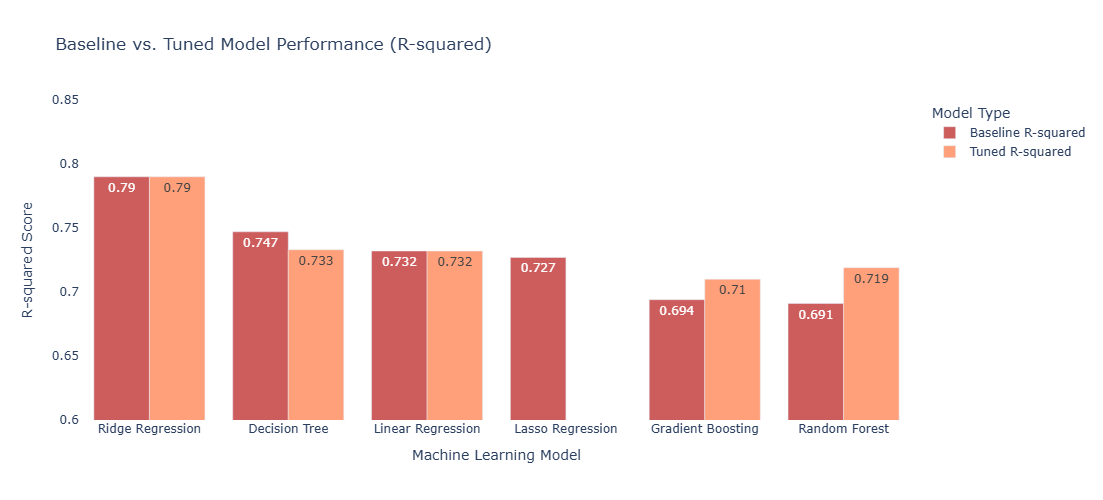

In [257]:
# 2. Create and Display the Interactive Bar Chart 

fig = go.Figure()

# Add Baseline R2 scores
fig.add_trace(go.Bar(
    x=baseline_df['Model'],
    y=baseline_df['R2'],
    name='Baseline R-squared',
    marker_color='indianred',
    text=baseline_df['R2'],
    textposition='auto'
))

# Add Tuned R2 scores
fig.add_trace(go.Bar(
    x=tuned_df['Model'],
    y=tuned_df['R2'],
    name='Tuned R-squared',
    marker_color='lightsalmon',
    text=tuned_df['R2'],
    textposition='auto'
))

# Update the layout for a clean, professional look
fig.update_layout(
    title='Baseline vs. Tuned Model Performance (R-squared)',
    xaxis_title='Machine Learning Model',
    yaxis_title='R-squared Score',
    barmode='group',
    yaxis=dict(range=[0.6, 0.85]), # Zoom in on the relevant R2 score range
    legend_title_text='Model Type',
    plot_bgcolor='white',
    width=900,
    height=500
)

# Show the interactive plot
fig.show()


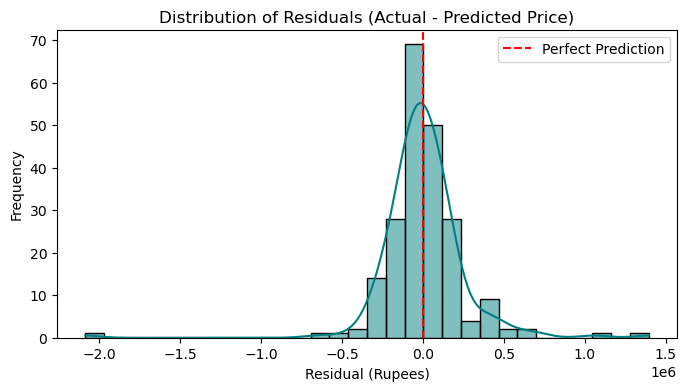

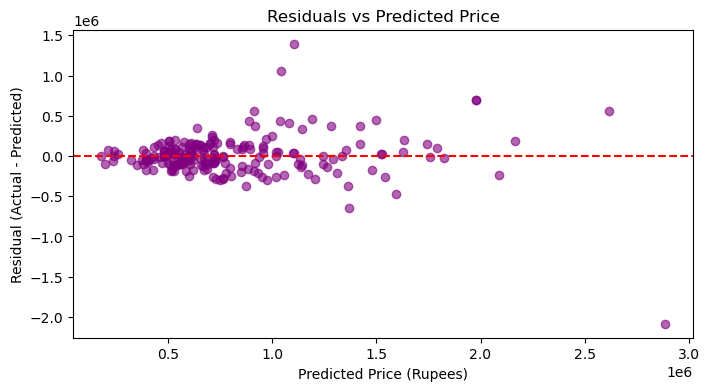

In [262]:
# Calculate residuals
residuals = y_test - y_pred

# Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, color='teal')
plt.title('Distribution of Residuals (Actual - Predicted Price)')
plt.xlabel('Residual (Rupees)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label="Perfect Prediction")
plt.legend()
plt.show()

# Scatter plot: Predicted vs Residuals
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Price')
plt.xlabel('Predicted Price (Rupees)')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

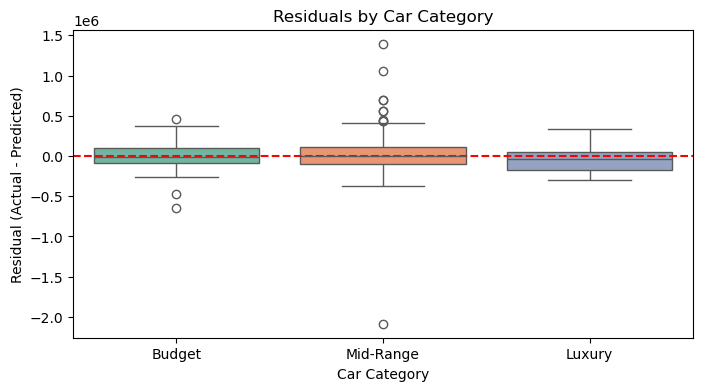

In [263]:
# X_test has a 'Category' column
results_df = X_test.copy()
results_df['ActualPrice'] = y_test.values
results_df['PredictedPrice'] = y_pred
results_df['Residual'] = results_df['ActualPrice'] - results_df['PredictedPrice']

plt.figure(figsize=(8, 4))
sns.boxplot(data=results_df, x='Category', y='Residual', palette='Set2')
plt.title('Residuals by Car Category')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Car Category')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

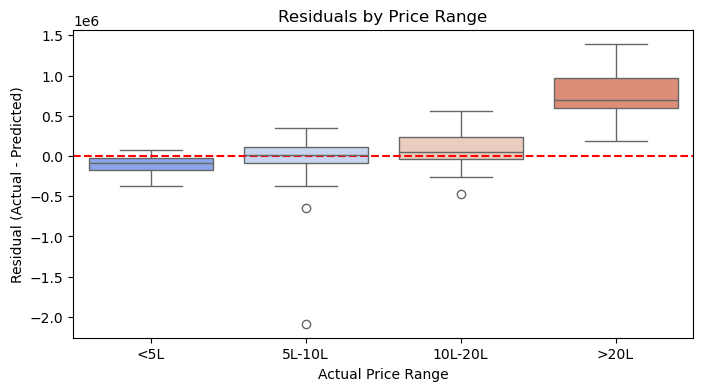

In [264]:
# Create price bins
results_df['PriceRange'] = pd.cut(results_df['ActualPrice'], bins=[0, 500000, 1000000, 2000000, 1e7],
                                  labels=['<5L', '5L-10L', '10L-20L', '>20L'])

plt.figure(figsize=(8, 4))
sns.boxplot(data=results_df, x='PriceRange', y='Residual', palette='coolwarm')
plt.title('Residuals by Price Range')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Price Range')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

# 10. Saving the Final Model and Preprocessor

In [258]:
# Select the best model from your tuned results
best_model = tuned_results['Ridge Regression']['model'] 

# Save the model object to a file
joblib.dump(best_model, 'ridge_regression_model.pkl')

# Save the preprocessor object to a file
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Final model ('ridge_regression_model.pkl') and preprocessor ('preprocessor.pkl') have been saved successfully!")

Final model ('ridge_regression_model.pkl') and preprocessor ('preprocessor.pkl') have been saved successfully!


# 11. Deployment and Prediction on New Data

In [259]:
import joblib
import pandas as pd
import numpy as np

# Load the saved model and preprocessor from the files ---
loaded_model = joblib.load('ridge_regression_model.pkl')
loaded_preprocessor = joblib.load('preprocessor.pkl')


def predict_car_price(car_details):
    """
    Loads the saved model and preprocessor to predict the price of a car.
    
    Args:
        car_details (dict): A dictionary containing the car's features.
        
    Returns:
        float: The predicted price of the car.
    """
    
    # 1. Convert new data into a DataFrame ---
    new_car_df = pd.DataFrame([car_details])
    
    # 2. Apply the SAME Feature Engineering as in training ---
    
    # a. Create 'CarAge'
    current_year = 2025
    new_car_df['CarAge'] = current_year - new_car_df['ModelYear']
    
    # b. Create 'Category'
    luxury_brands = ['MERCEDES BENZ', 'BMW', 'AUDI', 'VOLVO', 'JEEP']
    mid_range_brands = ['TOYOTA', 'HONDA', 'HYUNDAI', 'VOLKSWAGEN', 'KIA', 'SKODA','FIAT','MG','MITSUBISHI','CHEVROLET','ISUZU','FORD']
    
    def categorize_brand(company):
        if company in luxury_brands:
            return 'Luxury'
        elif company in mid_range_brands:
            return 'Mid-Range'
        else:
            return 'Budget'
            
    new_car_df['Category'] = new_car_df['Company'].apply(categorize_brand)

    # 3. Use the loaded preprocessor to transform the new data ---
    # The preprocessor already knows which columns are numerical/categorical
    # and how to handle them based on how it was fitted on the training data.
    new_car_processed = loaded_preprocessor.transform(new_car_df)
    
    # 4. Use the loaded model to make a prediction ---
    predicted_price = loaded_model.predict(new_car_processed)
    
    return predicted_price[0]

# --- Example Usage: Predict the Price of a Car ---
# ==============================================================================

# Let's predict the price for a 2016 Honda City.
# All original features must be provided.
example_car = {
    'Company': 'HONDA',
    'Model': 'CITY',
    'FuelType': 'Petrol',
    'Colour': 'Silver',
    'Kilometer': 50000,
    'BodyStyle': 'SEDAN',
    'TransmissionType': 'Manual',
    'Owner': '1st Owner',
    'City': 'Delhi',
    'Warranty': 1,
    'QualityScore': 8.5,
    'ModelYear': 2016 
    # The other columns like 'Variant' were dropped, so we don't need them here.
}


# Get the prediction
predicted_value = predict_car_price(example_car)

# Display the result in a user-friendly format
print(f"Car Details: 2016 Honda City, Manual, 50,000 km")
print("---------------------------------------------")
print(f"Predicted Market Price: ₹{predicted_value:,.2f}")

Car Details: 2016 Honda City, Manual, 50,000 km
---------------------------------------------
Predicted Market Price: ₹774,531.58
